![](2.png)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

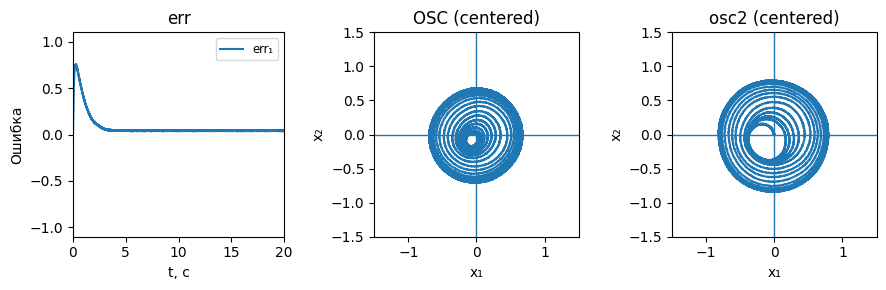

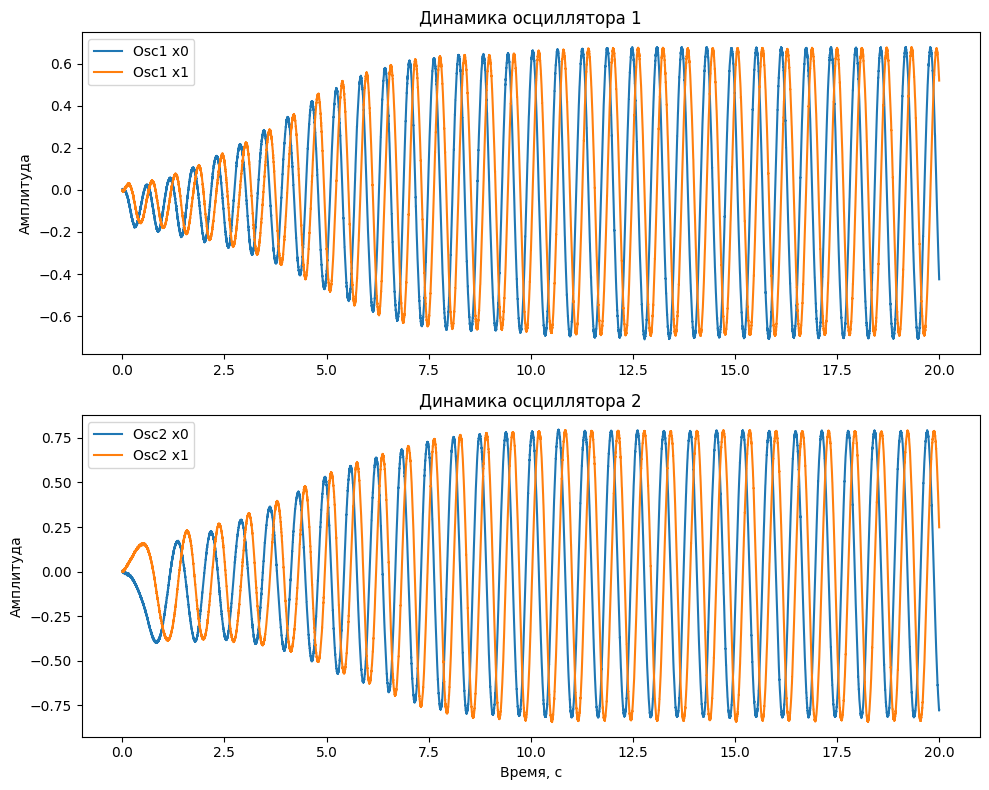

In [12]:

# # Toy model of predictive coding network with controlled oscillators

# Toy model of predictive coding network implemented in Nengo.
# The code realizes "predictive coding light" concept. The error signal teaches the integrator of upper hierarchy and becomes zero when finished teaching. The input signal and the signal from integrator specify the current error.
# 
# Used in eye control?
# Movement pacing

# Version 2.
# Error fixed:
# - Different names are given to different recurrent functions
# - Stabilization of oscillation amplitude is added

# prepare environment with python 3.9
#!pip install nengo
#!pip install nengo-gui
import matplotlib.pyplot as plt

import nengo

model = nengo.Network()

# integrator part is taken from Nengo summer school lecture 4
# integrator equation
# dx/dt = u(t)
# where u(t) is the input stimulus

# Parameters
tau_synapse = 0.2 # should be reasonably large
omega = 10 # oscillation frequency
gamma = 1 # decay/amplification rate

with model:
    # Integrator part
    
    err = nengo.Ensemble(n_neurons=100, dimensions=1)
    layer1 = nengo.Ensemble(n_neurons=100, dimensions=1)
    stim = nengo.Node(1)
    layer2 = nengo.Ensemble(n_neurons=100, dimensions=1)
    nengo.Connection(stim,layer1)
    nengo.Connection(layer1, err)
    
    def forward(u):
        return tau_synapse*u
    # feedforward error
    nengo.Connection(err, layer2, function=forward, synapse=tau_synapse)
    
    def recurrent_integ(x):
        return x
    nengo.Connection(layer2, layer2, function=recurrent_integ, synapse=tau_synapse)
    
    nengo.Connection(layer2, err, transform=-1) # feedback to the error population
    
    # Oscillator part
    
    # adding controlled oscillators
    osc1 = nengo.Ensemble(n_neurons=500, dimensions=4, radius=2)
    osc2 = nengo.Ensemble(n_neurons=500, dimensions=4, radius=2)
    
    def recurrent_osc(x):
        return [-tau_synapse*x[2]*omega*x[1]-tau_synapse*gamma*x[3]*x[0]+x[0], 
                 tau_synapse*x[2]*omega*x[0]+x[1]]
    
    nengo.Connection(osc1,osc1[:2], function=recurrent_osc, synapse=tau_synapse)
    nengo.Connection(osc2,osc2[:2], function=recurrent_osc, synapse=tau_synapse)
    nengo.Connection(layer1, osc1[2])   
    nengo.Connection(layer2, osc2[2])      
    
    # adding amplitude stabilization
    amplitude = nengo.Node(1) # desired oscillation amplitude

    # Ensembles that calculate amplitude error
    amp_err1 = nengo.Ensemble(n_neurons=100, dimensions=1)
    amp_err2 = nengo.Ensemble(n_neurons=100, dimensions=1)
        
    def square(x):
        return x*x
    
    def square2(x):
        return x[0]*x[0]+x[1]*x[1]
    
    nengo.Connection(amplitude, amp_err1, function=square, transform=-1)
    nengo.Connection(amplitude, amp_err2, function=square, transform=-1)
    
    nengo.Connection(amp_err1,osc1[3]) # feedforward amplitude control
    nengo.Connection(amp_err2,osc2[3]) # feedforward amplitude control
    
    # feedback connections to error
    nengo.Connection(osc1, amp_err1, function=square2) 
    nengo.Connection(osc2, amp_err2, function=square2)    

    p_err    = nengo.Probe(err,    synapse=0.1)
    p_l1     = nengo.Probe(layer1, synapse=0.1)
    p_l2     = nengo.Probe(layer2, synapse=0.1)
    p_osc1   = nengo.Probe(osc1[:2], synapse=0.1)
    p_osc2   = nengo.Probe(osc2[:2], synapse=0.1)
    
with nengo.Simulator(model, dt=0.001) as sim:
    sim.run(20.0)

# 2. Извлечение данных
t         = sim.trange()         # (N,)
data_osc  = sim.data[p_osc1]      # (N,3)
data_osc2 = sim.data[p_osc2]     # (N,3)
data_err  = sim.data[p_err]      # (N,3)

# 6. Рисуем три панели
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# 6.1 Ошибка err(t)
ax = axes[0]
ax.plot(t, data_err, label='err₁')
ax.set_title('err')
ax.set_xlabel('t, с')
ax.set_ylabel('Ошибка')
ax.set_xlim(0, t[-1])
ax.set_ylim(-1.1, 1.1)
ax.legend(loc='upper right', fontsize='small')

# 6.2 OSC (centered)
ax = axes[1]
ax.plot(data_osc[:,1], data_osc[:,0])
ax.set_title('OSC (centered)')
ax.set_xlabel('x₁'); ax.set_ylabel('x₂')
ax.axhline(0, linewidth=1)
ax.axvline(0, linewidth=1)
ax.set_aspect('equal','box')
ax.set_xlim(-1.5, 1.5); ax.set_ylim(-1.5, 1.5)

# 6.3 osc2 (centered)
ax = axes[2]
ax.plot(data_osc2[:,0], data_osc2[:,1])
ax.set_title('osc2 (centered)')
ax.set_xlabel('x₁'); ax.set_ylabel('x₂')
ax.axhline(0, linewidth=1) 
ax.axvline(0, linewidth=1)
ax.set_aspect('equal','box')
ax.set_xlim(-1.5,1.5); ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

# Визуализация результатов
plt.figure(figsize=(10, 8))

# 2) Осциллятор 1
plt.subplot(2, 1, 1)
plt.plot(t, sim.data[p_osc1][:, 0], label='Osc1 x0')
plt.plot(t, sim.data[p_osc1][:, 1], label='Osc1 x1')
plt.ylabel('Амплитуда')
plt.title('Динамика осциллятора 1')
plt.legend()

# 3) Осциллятор 2
plt.subplot(2, 1, 2)
plt.plot(t, sim.data[p_osc2][:, 0], label='Osc2 x0')
plt.plot(t, sim.data[p_osc2][:, 1], label='Osc2 x1')
plt.xlabel('Время, с')
plt.ylabel('Амплитуда')
plt.title('Динамика осциллятора 2')
plt.legend()

plt.tight_layout()
plt.show()
